In [327]:
import pandas as pd
import numpy as np
import datetime as dt
import math
import matplotlib.pyplot as plt
import pytz

from pandas.tseries.offsets import BDay, Day
from tqdm import tqdm

PATH = "C:/Users/jackl/OneDrive/Documents/finance_research/japan_qe/"
pd.options.mode.chained_assignment = None

In [328]:
def adjust_header(df):
    first_row = pd.DataFrame(df.columns).T
    first_row.columns = ['date', 'vlm']
    df.columns = ['date', 'vlm']
    df = first_row.append(df)
    df = df.reset_index(drop=True)
    return df

In [575]:
def adjust_dates(df, year):
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['hour'] = df['date'].dt.hour
    df['minute'] = df['date'].dt.minute
    df = df.drop(columns=['date'])
    
    if df['month'].iloc[-1] == 12:
        dec_list = list(df[df['month']==12].index)
        for i in range(len(dec_list)):
            try:
                if dec_list[i] - dec_list[i-1] > 1: 
                    break
            except:
                pass

        same_yr_indices = list(range(len(df)))[:dec_list[i]] 
        last_yr_indices = list(range(len(df)))[dec_list[i]:] 

    else: 
        same_yr_indices = list(range(len(df)))
        last_yr_indices = []

    same_yr_df = df.iloc[same_yr_indices]
    last_yr_df = df.iloc[last_yr_indices]

    same_yr_df['year'] = year
    last_yr_df['year'] = year - 1
    df = pd.concat([same_yr_df, last_yr_df])

    df['date_full'] = pd.to_datetime(df.drop(columns='vlm'))
    df['date_full'] = pd.to_datetime(df['date_full'].dt.tz_localize('EST').dt.tz_convert('Asia/Tokyo'))
    df['hour'] = df['date_full'].dt.hour 
    df['minute'] = df['date_full'].dt.minute
    df['date'] = pd.to_datetime(df['date_full'].dt.date)
    
    df = df.drop(columns=['day', 'month'])
    return df

In [576]:
def convert_values(val): 
    val = str(val)
    if val[-1]=='k': 
        val = float(val[:-1]) * 10 ** 3
    elif val[-1]=='M': 
        val = float(val[:-1]) * 10 ** 6
    else:
        val = float(val)
    
    return val

In [611]:
def get_vlm_df(df):
    df['session'] = df['date_full'].apply(lambda x: 'A' if x.hour in [8, 9, 13, 14, 15] else 'M')
    df['session_12'] = df['date_full'].apply(lambda x: 'A' if x.hour in [8, 9, 12, 13, 14, 15] else 'M')
    df['session_11'] = df['date_full'].apply(lambda x: 'A' if x.hour in [8, 9, 11, 12, 13, 14, 15] else 'M')

    df['date'] = pd.to_datetime(df['date_full'].dt.date)
    vlm_df1 = df[['date', 'session', 'vlm']].groupby(['date', 'session']).sum().reset_index()
    vlm_df2 = df[['date', 'session_12', 'vlm']].groupby(['date', 'session_12']).sum().reset_index()
    vlm_df3 = df[['date', 'session_11', 'vlm']].groupby(['date', 'session_11']).sum().reset_index()

    vlm_df12 = pd.merge(vlm_df1, 
                        vlm_df2, 
                        left_on=['date', 'session'], 
                        right_on=['date', 'session_12'], 
                        suffixes=[None, '_12']).drop(columns=['session_12'])

    vlm_df = pd.merge(vlm_df12, 
                      vlm_df3, 
                      left_on=['date', 'session'], 
                      right_on=['date', 'session_11'], 
                      suffixes=[None, '_11']).drop(columns=['session_11'])
    
    vlm_df['year'] = vlm_df['date'].dt.year
    return vlm_df

In [612]:
def main(p, vlm=True):
    df_list = []
    for year in tqdm(range(2010, 2021)):
        df = pd.read_excel(PATH+p, sheet_name=str(year))
        df = adjust_header(df)
        df = adjust_dates(df, year)
        df['vlm'] = df['vlm'].apply(lambda x: convert_values(x))
        df_list.append(df)

    df = pd.concat(df_list).drop_duplicates()
    if vlm==True:
        vlm_df = get_vlm_df(df)
    else:
        vlm_df = df
    
    return vlm_df

In [613]:
boj_df = pd.read_pickle(PATH+'checkpoint_data/boj_purchases_stock_level_v2.pkl')

## Action Commands

In [623]:
fr_df = main('raw_data/bloomberg/9983_master_volume.xlsx', vlm=False)
# av_df = main('raw_data/bloomberg/6857_master_volume.xlsx')

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.21it/s]


In [624]:
fr_sedol, av_sedol = '6332439', '6870490'

In [625]:
fr_df = pd.merge(fr_df, 
                 boj_df[boj_df['sedol'].isin([fr_sedol])][['date', 'shares_purchased']], 
                 on=['date'], 
                 how='left').sort_values('date')

# av_df = pd.merge(av_df, 
#                  boj_df[boj_df['sedol'].isin([av_sedol])][['date', 'shares_purchased']], 
#                  on=['date'], 
#                  how='left')

In [626]:
fr_df['shares_purchased'] = fr_df['shares_purchased'].apply(lambda x: 0 if math.isnan(x)==True else x)
# av_df['shares_purchased'] = av_df['shares_purchased'].apply(lambda x: 0 if math.isnan(x)==True else x)

In [629]:
fr_df.drop(columns=['date_full']).to_stata(PATH+'test.dta')

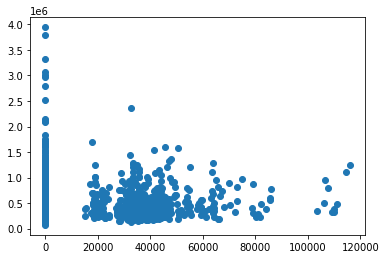

In [461]:
plt.scatter(x=fr_df_1['shares_purchased'], y=fr_df_1['vlm'])